In [1]:
from sklearn.datasets import load_diabetes
import matplotlib
import pandas as pd
import numpy as np
import altair as alt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import set_config
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score, train_test_split
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression

# Task 1: Dataset Exploration

In [2]:
# Load data

diabetes = load_diabetes()

df = pd.DataFrame(data=diabetes.data, columns=diabetes.feature_names)
y = diabetes.target

df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


In [ ]:
# Explore the dataset and describe features and target variables

print(df.info())

In [ ]:
print(df.describe())

We have 10 features that will be used to predict our target:

● Features:

    ○ age: Age of the patient.
    ○ sex: Gender of the patient.
    ○ bmi: Body mass index.
    ○ bp: Average blood pressure.
    ○ Six other quantitative variables derived from blood samples.
    
● Target: A continuous variable measuring the disease progression within a one-year
period. Larger values generally correspond to more severe progression of diabetes.

● All our values are floats, with no nulls.

●  442 observations (diabetes patients).

In [3]:
# split the dataset into testing and training using an 80-20 split.

X = pd.DataFrame(data=diabetes.data, columns=diabetes.feature_names)
y = diabetes.target

# seperating by X and y values will help calculate Adjusted R squared later
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.80, random_state = 42
)

# Task 2: Linear Regression Model

In [4]:
# Full Model
full_model = LinearRegression()
full_model.fit(X_train, y_train)
full_pred = full_model.predict(X_test)

# Metrics for Full Model
full_mse = mean_squared_error(y_test, full_pred)
full_r2 = r2_score(y_test, full_pred)
print("Full Model Metrics:")
print(f"MSE: {full_mse:.10f}, R²: {full_r2:.10f}")

Full Model Metrics:
MSE: 2900.1936284935, R²: 0.4526027630


45.26% of the variation in our target is accounted for by our model.

# Tasks 3/4: Implement Recursive Feature Elimination (RFE) & Analyze Feature Importance

Optimal number of features given threshold 0.01: 6


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,R2_Score
n_features,,,,,,,,,,,
1,0.000000,0.000000,998.577689,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.233350
2,0.000000,0.000000,732.109021,0.000000,0.000000,0.000000,0.000000,0.000000,562.226535,0.000000,0.452293
3,0.000000,0.000000,737.685594,0.000000,-228.339889,0.000000,0.000000,0.000000,680.224653,0.000000,0.445095
4,0.000000,0.000000,691.460102,0.000000,-592.977874,362.950323,0.000000,0.000000,783.168538,0.000000,0.446404
5,0.000000,0.000000,597.892739,306.647913,-655.560612,409.622184,0.000000,0.000000,728.643647,0.000000,0.438201
6,0.000000,-215.267423,557.314167,350.178667,-851.515734,591.093315,0.000000,0.000000,803.121285,0.000000,0.462777
7,0.000000,-235.364224,551.866448,362.356114,-660.643160,343.348089,0.000000,185.140764,664.774591,0.000000,0.458255
8,0.000000,-233.754686,550.744365,363.791753,-947.823133,541.585796,172.250588,277.741072,761.921177,0.000000,0.455901
9,0.000000,-236.649588,542.799508,354.211438,-936.350589,528.796592,167.800414,270.396514,744.447429,53.350483,0.458659


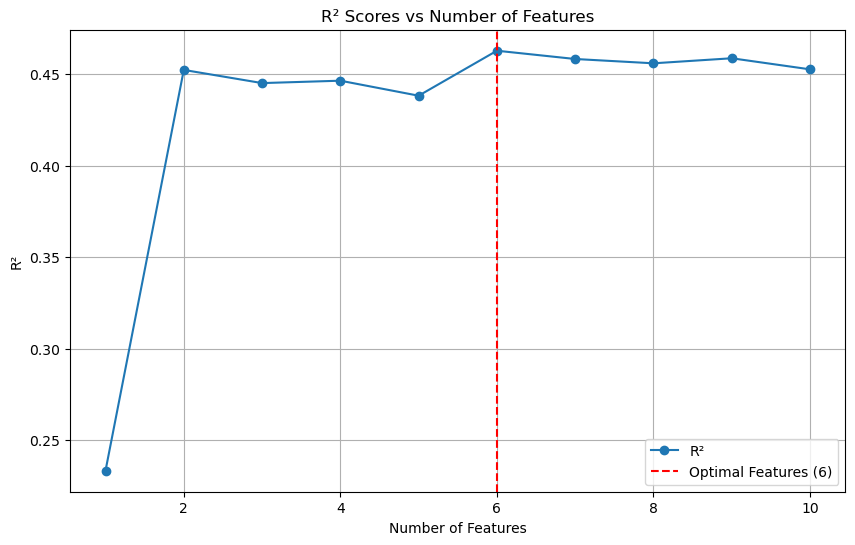

In [5]:
def rfe_starting_with_all_features():
    rfe_results = []
    feature_names = diabetes.feature_names
    threshold = 0.01

    for k in range(len(feature_names), 0, -1):
        rfe = RFE(estimator=full_model, n_features_to_select=k)
        rfe.fit(X_train, y_train)
    
        current_r2 = r2_score(y_test, rfe.predict(X_test))

        # put 0 if the feature isn't selected
        coef_map = {name: 0.0 for name in feature_names}
        selected_features = [feature_names[i] for i in range(len(feature_names)) if rfe.support_[i]]

        for name, coef in zip(selected_features, rfe.estimator_.coef_):
            coef_map[name] = coef
    
        # Store results
        coef_map['n_features'] = k
        coef_map['R2_Score'] = current_r2
        rfe_results.append(coef_map)

    table_df = pd.DataFrame(rfe_results).set_index('n_features').sort_index()

    # getting the largest count where the improvement is above the defined threshold 0.01
    optimal_n = 1
    for i in range(2, len(feature_names), 1):
        improvement = table_df.loc[i, 'R2_Score'] - table_df.loc[i-1, 'R2_Score']
        if improvement > threshold:
            optimal_n = i
    print(f"Optimal number of features given threshold {threshold}: {optimal_n}")
    return table_df, optimal_n

results_table, optimal_n = rfe_starting_with_all_features()
display(results_table)

plt.figure(figsize=(10, 6))
plt.plot(results_table.index, results_table['R2_Score'], marker='o', label='R²')
plt.axvline(optimal_n, color='red', linestyle='--', label=f'Optimal Features ({optimal_n})')
plt.title("R² Scores vs Number of Features")
plt.xlabel("Number of Features")
plt.ylabel("R²")
plt.legend()
plt.grid()
plt.show()

My code above starts with 10 features and decreases by 1 feature incrementally, tracking each R^2 value and coefficents in a table. Then to find the optimal amount of features, it checks each R^2, and if it improves by at least the desired threshold I defined to be 0.01, then it is considered the optimal model. This method allowed me to find the optimal number of features as 6 (sex, bmi, s1, s2, , s5, and s6) given a threshold of 0.01. Finally, I graphed my results. 

2. The three most important features are bmi, s1, and s5 because their coefficients are furthest from 0 during each iteration, shown by my table. Those 3 features alone are able to explain 44.51% of the variance in the target. This is not far from the 46.27% of variance explained from the optimal 6-feature model. Choosing these 3 features, given they have similar R^2, would give us a less complex model for similar model results. Changing our threshold value based on how much accuracy we're willing to give up for less complexity is the clear goal of RFE.

3. Our baseline model, with all 10 features, has R^2 of 0.4526, meaning 45.26% of the variation in our target is accounted for by our model. The RFE process removed the least important feature, or the feature with coefficient closest to 0, one at a time. My results showed that removing age, s6, s3, then s4, left us with the best r^2 given our threshold. Therefore, our optimal model explains 46.28% of the variation in the target using the 6 remaining features sex, bmi, s1, s2, , s5, and s6.

# Task 5: Reflection

1. I learned that the way RFE works is by iteratively elimating the least important features to find the model that gives us the best R^2. I learned that it's important to choose a good threshold for how much accuracy you're willing to part with in exchange for model simplicity. The difference in R^2 from a 2-feature model to our optimal model (6 features) is very small, so it may be worth using just 2 features depending on the circumstance. 

2. RFE removes the coefficents with the smallest absolute value, whereas Lasso's methodology involves minimizing the sum of the absolute values of the coefficients by penalizing large coefficients. They both aim to improve model performance by reducing the number of features. 

3. Age of the patient is the worst predictor (out of our 10 features) for predicting our target, followed by s6 and s3. The best predictors we have are bmi of the patient, then s5 and s1. 